<div style="
    background: linear-gradient(90deg, #0f2027 0%, #2c5364 100%);
    padding: 32px 0 32px 0;
    border-radius: 15px;
    text-align: center;
    margin-bottom: 30px;
">
  <h1 style="color: #fff; letter-spacing: 2px; font-size: 2.7rem; margin: 0; font-weight: 800;">
    Building Scalable AI with Ray
  </h1>
</div>


<h2 style="color: #0f2027; background: linear-gradient(90deg, #43cea2 0%, #185a9d 100%); padding: 12px 0; border-radius: 8px; text-align:center; font-size: 2rem; letter-spacing: 1px;">
   <span style="color: #fff;">Introduction</span> 
</h2>

## What is Ray ?

- **Open-source project** under PyTorch Foundation
- **Open-source distributed scheduler** for stateless tasks & stateful actors  
- **Key features:** task graphs, resource-aware, fast data transfer, GPU/custom resources  
- **Infra:** in-memory object store, fault-tolerant design  
- **Ecosystem:** Data, Train, Tune, Serve, RLlib  
- **User-friendly Python APIs**


<div align="center"><img src="assets/img01.png" alt="Intro to Ray" width="70%"></div>

| Concept | What It Is | Why It Matters (The Problem It Solves) |
| :--- | :--- | :--- |
| **`@ray.remote`** | A decorator to mark Python code for parallel execution. | The magic switch to turn a normal function or class into a distributed building block. |
| **Task** | A remote, stateless function call. | **Problem:** My code is slow because it only uses one core. A Task lets you run a function on any available core. |
| **Actor** | A remote, stateful class instance. | **Problem:** My parallel tasks need to share and update a common state (like a counter or a model). |
| **`.remote()`** | The syntax used to execute a Task or an Actor method. | The command to "send this work to the Ray cluster" instead of running it here. |
| **`ObjectRef`** | A "future" or a "receipt" for a result being computed. | The placeholder you get back instantly after calling `.remote()`, allowing your code to continue without waiting. |
| **`ray.get()`** | The command to retrieve the actual result from an `ObjectRef`. | **Problem:** My parallel work has been sent out; now I need the final answers back. |
| **`ray.put()`** | A command to place a large object into shared memory. | **Problem:** Sending the same large dataset (e.g., a big model) to every task is slow and wasteful. |

## Ray `Task`

<div align="center"><img src="assets/img02.png" alt="Ray Task" width="70%"></div>

#### Example of a sequential process (`without Ray`)

Let's `run` it!

In [1]:
!python code/sequential_process.py

Processed 8 images in 8.00 seconds.


#### Example of the same process but using `Ray Task`

Let's `run` it!

In [2]:
!python code/parallel_process.py

2025-12-11 01:20:30,993	INFO worker.py:1837 -- Connecting to existing Ray cluster at address: 10.0.149.226:6379...
2025-12-11 01:20:31,004	INFO worker.py:2014 -- Connected to Ray cluster. View the dashboard at https://session-byhavyr5h7v1ahhdvgc2eivb5j.i.anyscaleuserdata.com 
2025-12-11 01:20:31,040	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_bdc340b9111ae45e6de7b188f47058f94766f4a8.zip' (12.55MiB) to Ray cluster...
2025-12-11 01:20:31,086	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_bdc340b9111ae45e6de7b188f47058f94766f4a8.zip'.
/home/ray/anaconda3/lib/python3.12/site-packages/ray/_private/worker.py:2062: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
Processed 8 images in 3.55 seconds.


## Ray `Actors`

In [3]:
from IPython.display import Code

Code("code/ray_actor.py")

import ray

# 1. Initialize Ray
if not ray.is_initialized():
    ray.init()

# 2. Define the Actor (Stateful Worker)
@ray.remote
class Counter:
    def __init__(self):
        self.count = 0  # <--- This is the "State"

    def increment(self):
        self.count += 1
        return self.count

    def get_count(self):
        return self.count

# Step 1:Create four Counter actors and increment each Counter once and get the results. These tasks all happen in parallel.
counters = [Counter.remote() for _ in range(4)]
results1 = ray.get([c.increment.remote() for c in counters])
print("Initial counts: ", results1)

# Step 2: Increment the first Counter five times. These tasks are executed sequentially and share state.
results2 = ray.get([counters[0].increment.remote() for _ in range(5)])
print("Incremented first counter five times: ", results2)
_ = ray.get([c.get_count.remote() for c in counters])
print("Get the counts: ", _)

# Step 3: Increment each Counter once and get the results. These tasks all happen in parallel.
results3 = ray.get([c.increment.remote() for c in counters])
print("Look at the final counts after incrementing each counter once: ", results3)

<div align="center"><img src="assets/ray_actors.jpg" alt="actors" width="80%"></div>


Let's `run` it!

In [4]:
!python code/ray_actor.py

2025-12-11 01:20:35,982	INFO worker.py:1837 -- Connecting to existing Ray cluster at address: 10.0.149.226:6379...
2025-12-11 01:20:35,993	INFO worker.py:2014 -- Connected to Ray cluster. View the dashboard at https://session-byhavyr5h7v1ahhdvgc2eivb5j.i.anyscaleuserdata.com 
2025-12-11 01:20:36,028	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_5189d840c52217ae2675023cb49d82e90ea111a0.zip' (12.55MiB) to Ray cluster...
2025-12-11 01:20:36,072	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_5189d840c52217ae2675023cb49d82e90ea111a0.zip'.
/home/ray/anaconda3/lib/python3.12/site-packages/ray/_private/worker.py:2062: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
Initial counts:  [1, 1, 1, 1]
Incremented first counter five times:  [2

In [5]:
!python code/counter.py

Initial counts:  [1, 1, 1, 1]
Incremented first counter five times:  [2, 3, 4, 5, 6]
Get the counts:  [6, 1, 1, 1]
Look at the final counts after incrementing each counter once:  [7, 2, 2, 2]


## 

<h2 style="color: #0f2027; background: linear-gradient(90deg, #43cea2 0%, #185a9d 100%); padding: 12px 0; border-radius: 8px; text-align:center; font-size: 2rem; letter-spacing: 1px;">
   <span style="color: #fff;">Introduction to Ray Data</span> 
</h2>

## Streaming Execution 

Ray Data processes large datasets efficiently using a streaming model, which works with **blocks** as the basic units of data.

This approach replaces traditional bulk processing, where the entire dataset and intermediate results had to fit in the cluster's memory.

For example:

Here is a batch inference pipeline with a bulk processing approach.

<div align="center"><img src="assets/img04.png" alt="DP" width="80%"></div>

In contrast, here is the same batch inference pipeline with Ray Data's streaming model.

<div align="center"><img src="assets/img05.png" alt="DP with Ray" width="80%"></div>

Note how:
- Execution across stages of the pipeline is performed in parallel (i.e pipeline parallelism)
- Data is passed incrementally without blocking the pipeline

## Inside `Ray Dataset`

A Ray Dataset defines a data loading and processing pipeline. There are two main concepts in Ray Data:

- Datasets
- Blocks

The Dataset API is lazy, meaning that operations aren’t executed until you materialize or consume the dataset, like `show()`. 

**Block** is a set of rows representing single partition of the dataset. Blocks, as a collection of rows represented by columnar formats (like Arrow)
are the basic unit of data processing in Ray Data:

- Every dataset is `partitioned into a number of blocks`, then
- Processing of the `whole dataset is distributed and parallelized` at the block level (blocks are processed in parallel and for the most part independently)

Data processing is parallelized at the block level.

<div align="center"><img src="assets/img12.png" alt="DP" width="70%"></div>


## Ray `Dataset`

### `Step 1`: List the existing objects before executing the code


<div align="center"><img src="assets/img07.png" alt="DP" width="70%"></div>


In [6]:
!ray list objects

/home/ray/anaconda3/lib/python3.12/site-packages/ray/util/state/api.py:413: UserWarning: Callsite is not being recorded. To record callsite information for each ObjectRef created, set env variable RAY_record_ref_creation_sites=1 during `ray start` and `ray.init`.
  warnings.warn(warning_to_print)

======== List: 2025-12-11 01:20:41.351009 ========
Stats:
------------------------------
Total: 46

Table:
------------------------------
    OBJECT_ID                                                 OBJECT_SIZE    TASK_STATUS      ATTEMPT_NUMBER  REFERENCE_TYPE    CALL_SITE    TYPE      PID  IP
 0  00ffffffffffffffffffffffffffffffffffffff100000001ae1f505  529.000 B      FINISHED                      1  LOCAL_REFERENCE   disabled     DRIVER  79790  10.0.149.226
 1  00ffffffffffffffffffffffffffffffffffffff100000001be1f505  529.000 B      FINISHED                      1  LOCAL_REFERENCE   disabled     DRIVER  79790  10.0.149.226
 2  00ffffffffffffffffffffffffffffffffffffff100000001ce1f505  4.70

As expected, there are no objects created yet.

### `Step 2`: Prepare some data

Let's build a parquet dataset given a target in-memory size.

In [7]:
import gc
import ray
import numpy as np
import pandas as pd

In [8]:
df = pd.DataFrame(
    {
        "col1": np.random.rand(4500000).astype(np.float64),
        "col2": np.random.rand(4500000).astype(np.float64),
    }
)

memory_usage = (df.memory_usage(deep=True) / 1024**2).sum() # in MiB
print(f"Memory usage: {memory_usage} MiB")

# Write the dataframe to a parquet file 
df.to_parquet("/mnt/cluster_storage/data.parquet")

Memory usage: 68.66467666625977 MiB


In [9]:
df.head()

,col1,col2
0,0.550781,0.113873
1,0.474979,0.936458
2,0.832263,0.347986
3,0.672348,0.856866
4,0.087635,0.885677


Let's inspect the parquet file.


In [10]:
!ls -lh /mnt/cluster_storage/data.parquet

-rw-r--r-- 1 ray users 72M Dec 11 01:20 /mnt/cluster_storage/data.parquet


### `Step 3`: Create a materialized dataset

Let's create a `Dataset` from the parquet file using `read_parquet`

In [11]:
ds = ray.data.read_parquet("/mnt/cluster_storage/data.parquet")
ds

2025-12-11 01:20:44,961	INFO worker.py:1837 -- Connecting to existing Ray cluster at address: 10.0.149.226:6379...
2025-12-11 01:20:44,973	INFO worker.py:2014 -- Connected to Ray cluster. View the dashboard at https://session-byhavyr5h7v1ahhdvgc2eivb5j.i.anyscaleuserdata.com 
2025-12-11 01:20:45,007	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_e09a83135e76f44321af23fbbf7fefa1e2a30e7a.zip' (12.55MiB) to Ray cluster...
2025-12-11 01:20:45,057	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_e09a83135e76f44321af23fbbf7fefa1e2a30e7a.zip'.
/home/ray/anaconda3/lib/python3.12/site-packages/ray/_private/worker.py:2062: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


Dataset(num_rows=?, schema={col1: double, col2: double})

Let's materialize the `Dataset` using `materialize`

In [12]:
ds_materialized = ds.materialize() 
ds_materialized

2025-12-11 01:20:45,397	INFO logging.py:397 -- Registered dataset logger for dataset dataset_73_0
2025-12-11 01:20:45,414	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_73_0. Full logs are in /tmp/ray/session_2025-12-10_22-48-15_101330_2333/logs/ray-data
2025-12-11 01:20:45,415	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_73_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles]
2025-12-11 01:20:45,418	INFO streaming_executor.py:682 -- [dataset]: A new progress UI is available. To enable, set `ray.data.DataContext.get_current().enable_rich_progress_bars = True` and `ray.data.DataContext.get_current().use_ray_tqdm = False`.


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

2025-12-11 01:20:45,442	WARNING resource_manager.py:136 -- ⚠️  Ray's object store is configured to use only 27.0% of available memory (17.3GiB out of 64.0GiB total). For optimal Ray Data performance, we recommend setting the object store to at least 50% of available memory. You can do this by setting the 'object_store_memory' parameter when calling ray.init() or by setting the RAY_DEFAULT_OBJECT_STORE_MEMORY_PROPORTION environment variable.
2025-12-11 01:20:48,710	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_73_0 execution finished in 3.30 seconds


MaterializedDataset(
   num_blocks=1,
   num_rows=4500000,
   schema={col1: double, col2: double}
)

<div align="center"><img src="assets/img09.png" alt="DP" width="70%"></div>


### `Step 4`: List the objects again

We can see an object with a size of ~64 MiB has been created. 

In [13]:
!ray list objects

/home/ray/anaconda3/lib/python3.12/site-packages/ray/util/state/api.py:413: UserWarning: Callsite is not being recorded. To record callsite information for each ObjectRef created, set env variable RAY_record_ref_creation_sites=1 during `ray start` and `ray.init`.
  warnings.warn(warning_to_print)

======== List: 2025-12-11 01:20:50.741810 ========
Stats:
------------------------------
Total: 50

Table:
------------------------------
    OBJECT_ID                                                 OBJECT_SIZE    TASK_STATUS      ATTEMPT_NUMBER  REFERENCE_TYPE    CALL_SITE    TYPE      PID  IP
 0  00ffffffffffffffffffffffffffffffffffffff100000001ae1f505  529.000 B      FINISHED                      1  LOCAL_REFERENCE   disabled     DRIVER  79790  10.0.149.226
 1  00ffffffffffffffffffffffffffffffffffffff100000001be1f505  529.000 B      FINISHED                      1  LOCAL_REFERENCE   disabled     DRIVER  79790  10.0.149.226
 2  00ffffffffffffffffffffffffffffffffffffff100000001ce1f505  4.70

Note that we can verify the object was indeed generated by a Ray Data task by following the `CALL_SITE` of the object.

### `Step 5`: Inspect the blocks

Instead of browsing through all the objects in the object store, we can directly fetch the blocks of a materialized dataset using Ray Data.

It turns out that we can iterate over the blocks of a dataset using `iter_internal_ref_bundles`.


In [14]:
for ref_bundle in ds_materialized.iter_internal_ref_bundles():
    print(ref_bundle)

RefBundle(1 blocks,
  4500000 rows,
  schema=col1: double
col2: double
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 483,
  owns_blocks=False,
  blocks=(
    0: 4500000 rows, 73125000 bytes, slice=None (full block)
  )
)


A reference bundle `RefBundle` is simply a bundle of:
- a reference to the block
- metadata about the block

In [15]:
block_ref, block_metadata = ref_bundle.blocks[0]
block_ref

ObjectRef(eec07fcb04d81fa1ffffffffffffffffffffffff1300000002000000)

We can check the `Block size` as well. 

Ray Data bounds block sizes to avoid excessive communication overhead and prevent out-of-memory errors.

- Small blocks are good for latency and more streamed execution
- Large blocks reduce scheduler and communication overhead.
- The default range attempts to make a good tradeoff for most jobs.

Here are the default values that Ray Data uses:

In [16]:
max_block_size = ray.data.DatasetContext.get_current().target_max_block_size / 1024**2 # in MiB
min_block_size = ray.data.DatasetContext.get_current().target_min_block_size / 1024**2 # in MiB

print(f"Max block size: {max_block_size} MiB")
print(f"Min block size: {min_block_size} MiB")


Max block size: 128.0 MiB
Min block size: 1.0 MiB


A block is the basic unit of data that Ray Data stores in the object store and transfers over the network. 

Each block contains a disjoint subset of rows, and Ray Data loads and transforms these blocks in a distributed manner.

<div align="center"><img src="assets/img03.png" alt="Ray Data" width="80%"></div>

To fetch the block, we can use `ray.get`.

In [17]:
block = ray.get(block_ref)
block

pyarrow.Table
col1: double
col2: double
----
col1: [[0.5507811905831775,0.4749793855954353,0.8322631979989761,0.6723480373968092,0.08763515865987093,...,0.7076960563677858,0.6950829690954274,0.42779707802529665,0.3913126249473514,0.45187064001193034],[0.6145899342356278,0.48543041348408267,0.9244922467801089,0.47430145536739865,0.45476113828644305,...,0.9204014965698706,0.9111200214727543,0.7628209450011965,0.2568938692289242,0.5130488865617525],...,[0.20888830878498987,0.22393582952601654,0.34065473671178637,0.42642244267728446,0.9151776753375439,...,0.048382597226451884,0.334951635211331,0.1975867817105995,0.0158313441723138,0.1969462607920195],[0.3990611242848787,0.7641679480110783,0.9317274399091809,0.21480171704362794,0.6657094232144047,...,0.7602288123262055,0.6276749256132254,0.6927794485320834,0.6426174678782884,0.8474589345513998]]
col2: [[0.11387279928141902,0.9364579672396707,0.3479858749938989,0.8568658655586235,0.8856767824080762,...,0.10864828723946407,0.12969992798458652

Ray Data stores blocks as either pandas Dataframes or pyarrow Tables. In this case, when materializing from a `read_parquet`, the block is a pyarrow Table.

<!-- TODO - figure out adding info below: -->
<!-- Note, that regardless of the data type that Ray Data uses to store the block, Ray Data will convert the block to the required batch format when batching the data and transforming it. -->

In [18]:
type(block)

pyarrow.lib.Table

In this case, the block contains the same data as the original dataframe.

In [19]:
block.shape, df.shape

((4500000, 2), (4500000, 2))

let's clean up references to the objects we created so Ray can garbage collect them.

In [20]:
%xdel block
%xdel block_ref
%xdel ds
%xdel ds_materialized
%xdel ref_bundle
gc.collect()

1683

We can see that the object has been garbage collected.

In [21]:
!ray list objects

/home/ray/anaconda3/lib/python3.12/site-packages/ray/util/state/api.py:413: UserWarning: Callsite is not being recorded. To record callsite information for each ObjectRef created, set env variable RAY_record_ref_creation_sites=1 during `ray start` and `ray.init`.
  warnings.warn(warning_to_print)

======== List: 2025-12-11 01:20:53.620599 ========
Stats:
------------------------------
Total: 46

Table:
------------------------------
    OBJECT_ID                                                 OBJECT_SIZE    TASK_STATUS      ATTEMPT_NUMBER  REFERENCE_TYPE    CALL_SITE    TYPE      PID  IP
 0  00ffffffffffffffffffffffffffffffffffffff100000001ae1f505  529.000 B      FINISHED                      1  LOCAL_REFERENCE   disabled     DRIVER  79790  10.0.149.226
 1  00ffffffffffffffffffffffffffffffffffffff100000001be1f505  529.000 B      FINISHED                      1  LOCAL_REFERENCE   disabled     DRIVER  79790  10.0.149.226
 2  00ffffffffffffffffffffffffffffffffffffff100000001ce1f505  4.70

## 


<h2 style="color: #0f2027; background: linear-gradient(90deg, #43cea2 0%, #185a9d 100%); padding: 12px 0; border-radius: 8px; text-align:center; font-size: 2rem; letter-spacing: 1px;">
   <span style="color: #fff;">What are we going to build today ?</span> 
</h2>

## Scenario



We have a dataset of image prompts (in our example, animals) and another dataset with enhanced detail information for each record (in the demo, clothing the animal will wear).

Our end goal is to combine the prompts and details, then use a LLM to enhance to prompts further, employ an image gen model to create corresponding images, and produce batch output to storage.

<div align="center"><img src="assets/img13.png" alt="RD" width="80%"></div>

* Scalable data ingestion (`Batch image generation`)
* Transforming data using Ray Data pipelines and operators
* Scalable batch inference processing with accelerators
* Joining Ray Datasets and apply data transformation to joined columns
* Integrating scalable LLM inference and fractional resource scheduling


<div align="center"><img src="assets/img15.png" alt="RD" width="80%"></div>

### Ray Data motivation

It's pretty easy to write a Python script to manipulate strings and use models directly from Huggingface with code like the following:

```python
# Step 1: Load some model
pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16").to("cuda")

# Step 2: Perform the inference
image = pipe("A watercolor painting of a cat", num_inference_steps=1, guidance_scale=0.0).images[0]
```

<div align="center"><img src="assets/img06.png" alt="RD" width="80%"></div>

But we want to build a scalable data+AI processing pipeline. To do that, we want to ...

* leverage a scale-out cluster with multiple GPUs
* read data using as much of our cluster as is useful (parallel read)
* work with the data in chunks large enough to get benefits of scale (i.e., not suffer from excessive overhead relative to the number of records)
    * but also small enough to allow for flexible scheduling as it flows through our pipeline -- we don't want an enormous chunk to hold up processing, require excessive disk or network I/O, etc.
* assign work to, e.g., CPU nodes where GPU is not required; or to smaller, cheaper GPUs where large ones are not required
* adjust batching to optimize GPU use even when ideal batch size may be different for different operations
* handle arbitrarily large datasets by leveraging a streaming execution model
* minimize I/O costs by, e.g., fusing operations where possible
* produce predictable flow by managing backpressure (i.e., ensuring data doesn't "pile up" in between pipeline stages)
* optimize via lazy execution and flexible logical + physical planners

Ray Data is designed to address these requirements, allowing us to orchestrate at scale while still straightforward Python / Huggingface code we're used to.

### Agenda and steps for incremental implementation

1. Locate our datasets in shared storage
2. Read records using Ray Data and learn how to perform basic transformations
3. Generate images across multiple GPU nodes
4. Lab activity: generate images and store all of our prompts and outputs as parquet data
5. Join animal records against clothing outfit details to build a bigger prompt and generate enhanced images
6. Lab activity: generate and export just the images as PNG files
7. Leverage a LLM to further enhance the prompts, adding seasonal content and generate images from the full pipeline
8. Lab activity: parameterize the LLM-based component so see how Ray Data supports separation of concerns
9. Wrapup

<h2 style="color: #0f2027; background: linear-gradient(90deg, #43cea2 0%, #185a9d 100%); padding: 12px 0; border-radius: 8px; text-align:center; font-size: 2rem; letter-spacing: 1px;">
   <span style="color: #fff;">Let's get started! </span> 
</h2>

In [22]:
from diffusers import AutoPipelineForText2Image
from transformers import pipeline
from transformers.utils import logging
import numpy as np
import random
import ray
import torch
logging.set_verbosity_info()

## `Step 0`: Defining the dataset 

First, we need to get all of our data in some common location where the whole cluster can see it. This might be a blob store, NFS, database, etc.

Anyscale offers `/mnt/cluster_storage` as a NFS path.

In [23]:
!head data/animals.csv

id,animal
100,A watercolor painting of a cat
101,A digital illustration of a dog
102,A charcoal sketch of a rabbit
103,A clay sculpture of an owl
104,An oil painting of a fox
105,A pencil drawing of a horse
106,A digital painting of a penguin
107,A watercolor of a bear
108,An ink sketch of a raccoon


In [24]:
!cp data/animals.csv /mnt/cluster_storage/

<details>
    <summary style="font-size: small; color: ;"><b> Cluster Storage </b></summary>
<div align="center"><img src="assets/img09.png" alt="DP" width="70%"></div>
</details>

## `Step 1`: Read the data using `Ray Data`

Ray Data's `read_xxxx` methods (see I/O in Ray Docs for all the available formats and data sources) get us scalable, parallel reads.

In [25]:
animals = ray.data.read_csv('/mnt/cluster_storage/animals.csv')
animals.take_batch(3)

2025-12-11 01:20:59,643	INFO logging.py:397 -- Registered dataset logger for dataset dataset_76_0
2025-12-11 01:20:59,648	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_76_0. Full logs are in /tmp/ray/session_2025-12-10_22-48-15_101330_2333/logs/ray-data
2025-12-11 01:20:59,648	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_76_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> LimitOperator[limit=3]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- limit=3 3: 0.00 row [00:00, ? row/s]

2025-12-11 01:21:01,251	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_76_0 execution finished in 1.60 seconds


{'id': array([100, 101, 102]),
 'animal': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object)}

We can rename column, like this: 

In [26]:
animals.rename_columns({'animal' : 'prompt'}) \
       .take_batch(3)

2025-12-11 01:21:01,309	INFO logging.py:397 -- Registered dataset logger for dataset dataset_78_0
2025-12-11 01:21:01,313	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_78_0. Full logs are in /tmp/ray/session_2025-12-10_22-48-15_101330_2333/logs/ray-data
2025-12-11 01:21:01,314	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_78_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> LimitOperator[limit=3] -> TaskPoolMapOperator[Project]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- limit=3 3: 0.00 row [00:00, ? row/s]

- Project 4: 0.00 row [00:00, ? row/s]

2025-12-11 01:21:01,430	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_78_0 execution finished in 0.12 seconds


{'id': array([100, 101, 102]),
 'prompt': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object)}

<details>
    <summary style="font-size: small; color: ;"><b> Where are we now! </b></summary>
<div align="center"><img src="assets/step2.png" alt="Step2" width="70%"></div>
</details>



## `Step 2` : Generate Image 

We dont want to simply do this and process sequentially

```python
# Load some model
pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16").to("cuda")

# Perform the inference
image = pipe("A cinematic shot of a racoon wearing an italian priest robe.", num_inference_steps=1, guidance_scale=0.0).images[0]
```

Stateful tranformation of datasets -- in this example, `AI inference where the state` is the image gen model (`ImageGen`) -- is done with the following pattern.

1. Define a Python class (which Ray will later instantiate across the cluster as one more actor instances to do the processing)
2. Use Dataset's `map_batches` API to tell Ray to send batches of data to the `__call__` method in the actors instances
    - `map_batches` allows us to specify resource requirements, actor pool size, batch size, and more

In [27]:
class ImageGen():
    def __init__(self):
        self.pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16").to("cuda")
        
    def gen_image(self, prompts):
        return self.pipe(prompt=list(prompts), num_inference_steps=1, guidance_scale=0.0).images
    
    def __call__(self, batch):
        batch['image'] = self.gen_image(batch['prompt'])
        return batch

In [28]:
animals_images = animals.repartition(2) \
                        .rename_columns({'animal' : 'prompt'}) \
                        .map_batches(ImageGen, 
                                     num_gpus=1, 
                                     compute=ray.data.ActorPoolStrategy(size=2), 
                                     batch_size=8)

<details>
    <summary style="font-size: small; color: ;"><b> Where are we now! </b></summary>
<div align="center"><img src="assets/step3.png" alt="Step3" width="70%"></div>
</details>

Ray Datasets employ *lazy evaluation* for improved performance, so we can use APIs like `take_batch`, `take`, or `show` to trigger execution for development and testing purposes.

In [29]:
examples = animals_images.take_batch(3)

2025-12-11 01:21:01,584	INFO logging.py:397 -- Registered dataset logger for dataset dataset_82_0
2025-12-11 01:21:01,585	INFO limit_pushdown.py:140 -- Skipping push down of limit 3 through map MapBatches[MapBatches(ImageGen)] because it requires 8 rows to produce stable outputs
2025-12-11 01:21:01,590	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_82_0. Full logs are in /tmp/ray/session_2025-12-10_22-48-15_101330_2333/logs/ray-data
2025-12-11 01:21:01,591	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_82_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[Project] -> ActorPoolMapOperator[MapBatches(ImageGen)] -> LimitOperator[limit=3]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- Repartition 3: 0.00 row [00:00, ? row/s]

Split Repartition 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Project 5: 0.00 row [00:00, ? row/s]

- MapBatches(ImageGen) 6: 0.00 row [00:00, ? row/s]

- limit=3 7: 0.00 row [00:00, ? row/s]

100%|██████████| 1/1 [00:00<00:00,  1.78it/s]45, ip=10.0.173.154) 
(MapWorker(MapBatches(ImageGen)) pid=20545, ip=10.0.173.154) Failed to convert column 'image' into pyarrow array due to: Error converting data to Arrow: [<PIL.Image.Image image mode=RGB size=512x512 at 0x7BDD20882AE0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7BDD20883710>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7BDD208817F0>, <PIL...; falling back to serialize as pickled python objects
(MapWorker(MapBatches(ImageGen)) pid=20545, ip=10.0.173.154) Traceback (most recent call last):
(MapWorker(MapBatches(ImageGen)) pid=20545, ip=10.0.173.154)   File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/air/util/tensor_extensions/arrow.py", line 318, in _convert_to_pyarrow_native_array
(MapWorker(MapBatches(ImageGen)) pid=20545, ip=10.0.173.154)     pa_type = _infer_pyarrow_type(column_values)
(MapWorker(MapBatches(ImageGen)) pid=20545, ip=10.0.173.154)               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(

In [30]:
examples

{'id': array([100, 101, 102]),
 'prompt': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object),
 'image': array([<PIL.Image.Image image mode=RGB size=512x512 at 0x715F7955F440>,
        <PIL.Image.Image image mode=RGB size=512x512 at 0x715F78B93710>,
        <PIL.Image.Image image mode=RGB size=512x512 at 0x715F7956BBF0>],
       dtype=object)}

<details>
    <summary style="font-size: small; color: ;"><b> How the new transformed data looks like now ? </b></summary>
<div align="center"><img src="assets/img10.png" alt="Step3" width="70%"></div>
</details>



A watercolor painting of a cat


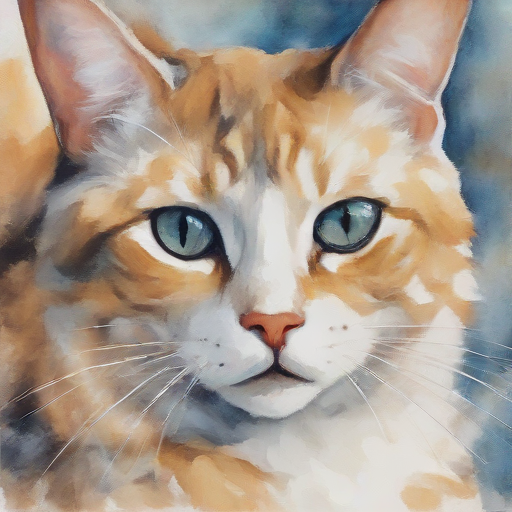

In [31]:
print(examples['prompt'][0])
examples['image'][0]


<div style="border: 2px solid #4F8EF7; background: #F3F8FF; border-radius: 10px; padding: 18px; margin: 18px 0;">
<h2 style="color: #25396f; margin-top: 0;">📝 <span style="color:#3971CC;">Lab:</span> Generate and Write All Output to Storage as <span style="color: #C678DD;">Parquet</span> Data</h2>

<ul style="font-size: 1.1em;">
  <li><b>Start</b> with the <span style="color: #A9A9A9;">Ray Dataset</span> you'd like to write.</li>
  <li><b>Check</b> the <a href="https://docs.ray.io/en/latest/data/api/input_output.html" target="_blank" style="color: #3971CC;">Ray Data Write API docs</a> to find a suitable <code>write</code> API.</li>
  <li><b>Remember</b> to write to a <span style="color: #228B22;">shared file location</span>, such as <code style="color: #228B22;">/mnt/cluster_storage</code>.</li>
</ul>
</div>

<details>
    <summary style="font-size: small; color: ;"><b> Where are we now! </b></summary>
<div align="center"><img src="assets/step4.png" alt="Step4" width="70%"></div>
</details>



In [32]:
# try your code here


<details>
    <summary style="font-size: small; color: ;"><b> Solution </b></summary>

 ```python
 animals_images.write_parquet('/mnt/cluster_storage/animals_images.parquet/')
 ```

<div align="center"><img src="assets/step5.png" alt="Step5" width="70%"></div>

</details>


<div align="center"><img src="assets/Part1_done.png" alt="Intro to Ray" width="70%"></div>

## `Step 3`: Improving the `prompt` using `JOIN`

<div align="center"><img src="assets/Part2.png" alt="Part2" width="70%"></div>

Ray Data supports a number of high-performance JOIN APIs.  
You can learn more here:  [Ray Data Join API Documentation](https://docs.ray.io/en/latest/data/joining-data.html)

We can use a `JOIN` to connect our `animal` records with a detailed prompt refinement unique to that record.

In [33]:
!cp data/outfits.csv /mnt/cluster_storage/

In [34]:
!head /mnt/cluster_storage/outfits.csv

100%|██████████| 1/1 [00:00<00:00,  7.14it/s]45, ip=10.0.173.154) 


id,outfit
100,red scarf
101,blue jacket
102,green hat
103,purple cloak
104,yellow sweater
105,pink blanket
106,orange bowtie
107,teal hoodie
108,violet vest


In [35]:
outfits = ray.data.read_csv('/mnt/cluster_storage/outfits.csv')
outfits.take_batch(3)

2025-12-11 01:21:22,497	INFO logging.py:397 -- Registered dataset logger for dataset dataset_84_0
2025-12-11 01:21:22,502	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_84_0. Full logs are in /tmp/ray/session_2025-12-10_22-48-15_101330_2333/logs/ray-data
2025-12-11 01:21:22,503	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_84_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> LimitOperator[limit=3]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- limit=3 3: 0.00 row [00:00, ? row/s]

100%|██████████| 1/1 [00:00<00:00,  7.13it/s]45, ip=10.0.173.154) 
2025-12-11 01:21:24,061	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_84_0 execution finished in 1.56 seconds


{'id': array([100, 101, 102]),
 'outfit': array(['red scarf', 'blue jacket', 'green hat'], dtype=object)}

In [36]:
animals_outfits = animals.join(outfits, 'inner', 1) \
                         .repartition(8)

animals_outfits.take_batch(3)

2025-12-11 01:21:24,120	INFO logging.py:397 -- Registered dataset logger for dataset dataset_87_0
/home/ray/anaconda3/lib/python3.12/site-packages/ray/anyscale/data/_internal/util/dependencies.py:42: UserWarning: Numba isn't available. Install numba>=0.61>=0.61 to get better performance for hash partitioning operations. Falling back to slower Python implementation for RayTurbo optimizations.
  warnings.warn(
2025-12-11 01:21:24,128	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_87_0. Full logs are in /tmp/ray/session_2025-12-10_22-48-15_101330_2333/logs/ray-data
2025-12-11 01:21:24,128	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_87_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles], InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> JoinOperatorWithPolars[Join(num_partitions=1)] -> AllToAllOperator[Repartition] -> LimitOperator[limit=3]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- ListFiles 3: 0.00 row [00:00, ? row/s]

- ReadFiles 4: 0.00 row [00:00, ? row/s]

- Join(num_partitions=1) 5: 0.00 row [00:00, ? row/s]

Shuffle 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Join 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Repartition 8: 0.00 row [00:00, ? row/s]

Split Repartition 9:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- limit=3 10: 0.00 row [00:00, ? row/s]

100%|██████████| 1/1 [00:00<00:00,  7.13it/s]45, ip=10.0.173.154) 
2025-12-11 01:21:27,409	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_87_0 execution finished in 3.04 seconds


{'id': array([100, 101, 102]),
 'animal': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object),
 'outfit': array(['red scarf', 'blue jacket', 'green hat'], dtype=object)}

In [37]:
# Expand the prompt to include the outfit
def expand_prompt(batch):
    batch['prompt'] = batch['animal'] + ' wearing a ' + batch['outfit']
    return batch

# Generate images for the dressed animals
dressed_animals = animals_outfits.map_batches(expand_prompt) \
                                 .map_batches(ImageGen, 
                                              batch_size=16, 
                                              compute=ray.data.ActorPoolStrategy(size=2), 
                                              num_gpus=1)

In [38]:
# Take a look at the first 3 records
examples = dressed_animals.take_batch(3)

2025-12-11 01:21:27,518	INFO logging.py:397 -- Registered dataset logger for dataset dataset_90_0
2025-12-11 01:21:27,519	INFO limit_pushdown.py:140 -- Skipping push down of limit 3 through map MapBatches[MapBatches(ImageGen)] because it requires 16 rows to produce stable outputs
2025-12-11 01:21:27,526	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_90_0. Full logs are in /tmp/ray/session_2025-12-10_22-48-15_101330_2333/logs/ray-data
2025-12-11 01:21:27,526	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_90_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles], InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> JoinOperatorWithPolars[Join(num_partitions=1)] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(expand_prompt)] -> ActorPoolMapOperator[MapBatches(ImageGen)] -> LimitOperator[limit=3]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- ListFiles 3: 0.00 row [00:00, ? row/s]

- ReadFiles 4: 0.00 row [00:00, ? row/s]

- Join(num_partitions=1) 5: 0.00 row [00:00, ? row/s]

Shuffle 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Join 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Repartition 8: 0.00 row [00:00, ? row/s]

Split Repartition 9:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(expand_prompt) 10: 0.00 row [00:00, ? row/s]

- MapBatches(ImageGen) 11: 0.00 row [00:00, ? row/s]

- limit=3 12: 0.00 row [00:00, ? row/s]

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]90, ip=10.0.173.154) 
(MapWorker(MapBatches(ImageGen)) pid=22239, ip=10.0.187.206) Failed to convert column 'image' into pyarrow array due to: Error converting data to Arrow: [<PIL.Image.Image image mode=RGB size=512x512 at 0x743418C6D1F0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x743413ACDC10>, <PIL.Image.Image image mode=RGB size=512x512 at 0x743413ACF170>, <PIL...; falling back to serialize as pickled python objects
(MapWorker(MapBatches(ImageGen)) pid=22239, ip=10.0.187.206) Traceback (most recent call last):
(MapWorker(MapBatches(ImageGen)) pid=22239, ip=10.0.187.206)   File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/air/util/tensor_extensions/arrow.py", line 318, in _convert_to_pyarrow_native_array
(MapWorker(MapBatches(ImageGen)) pid=22239, ip=10.0.187.206)     pa_type = _infer_pyarrow_type(column_values)
(MapWorker(MapBatches(ImageGen)) pid=22239, ip=10.0.187.206)               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(

In [39]:
examples

{'id': array([112, 113, 114]),
 'animal': array(['A digital illustration of a hedgehog', 'A sculpture of a dolphin',
        'A charcoal drawing of a wolf'], dtype=object),
 'outfit': array(['magenta jacket', 'lavender shawl', 'bronze belt'], dtype=object),
 'prompt': array(['A digital illustration of a hedgehog wearing a magenta jacket',
        'A sculpture of a dolphin wearing a lavender shawl',
        'A charcoal drawing of a wolf wearing a bronze belt'], dtype=object),
 'image': array([<PIL.Image.Image image mode=RGB size=512x512 at 0x71608BF5AC00>,
        <PIL.Image.Image image mode=RGB size=512x512 at 0x71608BD28380>,
        <PIL.Image.Image image mode=RGB size=512x512 at 0x71608BD11370>],
       dtype=object)}

<details>
    <summary style="font-size: small; color: ;"><b> How is the data look like now ? </b></summary>
<div align="center"><img src="assets/img11.png" alt="Ray Task" width="70%"></div></details>

A digital illustration of a hedgehog wearing a magenta jacket


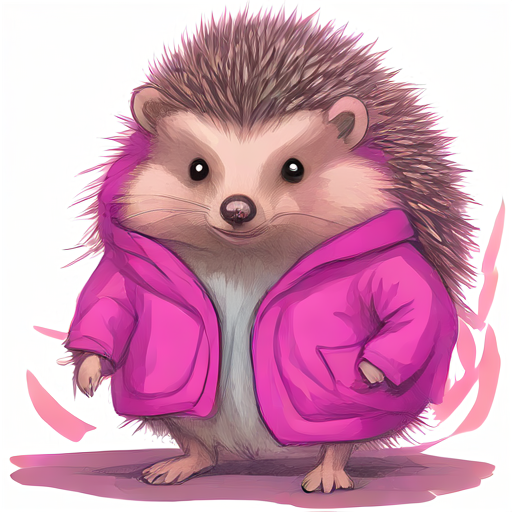

In [40]:
print(examples['prompt'][0])
examples['image'][0]

<div style="border: 2px solid #4F8EF7; background: #F3F8FF; border-radius: 10px; padding: 18px; margin: 18px 0;">
<h2 style="color: #25396f; margin-top: 0;">📝 <span style="color:#3971CC;">Lab:</span> Generate Images for Input Prompts &amp; Write Them to a Folder</h2>

<ul style="font-size: 1.1em;">
  <li><b>Convert</b> the image column to NumPy arrays using <code>np.array(my_pil_image)</code> together with <code>map_batches</code>.</li>
  <li><b>Use</b> <code>dataset.write_images(...)</code> to write the NumPy image arrays to a folder of your choice (e.g., <code>/mnt/cluster_storage/generated_images/</code>).</li>
  <li><b>Check</b> the <a href="https://docs.ray.io/en/latest/data/api/input_output.html#ray.data.Dataset.write_images" target="_blank" style="color: #3971CC;">Ray Data Write Images API Docs</a> for details.</li>
</ul>
</div>

<details>
    <summary style="font-size: small; color: ;"><b> Where are we now! </b></summary>
<div align="center"><img src="assets/step4_task.png" alt="Ray Task" width="70%"></div>
</details>


In [41]:
# try your code here


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]39, ip=10.0.187.206) 


<details>
    <summary style="font-size: small; color: ;"><b> Solution </b></summary>
 
 ```python
    def image_to_array(batch):
        batch['image'] = [np.array(i) for i in batch['image']]
        return batch
        
    dressed_animals.map_batches(image_to_array) \
                   .write_images('/mnt/cluster_storage/animals_images/', 'image')
 ```
</details>


<div align="center"><img src="assets/Part2_done.png" alt="Intro to Ray" width="70%"></div>

## `Step 4` :  Enhance pipeline with `LLM` generated prompt

We can leverage a LLM to create more varied and detailed image prompts -- as well as add dynamism like a seasonal element -- by adding a LLM batch inference step to the pipeline.

To implement this operation, we'll
1. Create a Python class to encasulate the logic and data transformtion
1. Use `map_batches` to route batches of data from our Ray Dataset through this transformation operation
1. Demonstrate Ray's support for fractional resource allocation, so that we can schedule 4 GPU-dependent operator instances with only 2 GPUs
1. Demonstrate the decoupling of operator batch sizes from each other (as well as from Dataset block size) to optimally use our models and GPUs

<div align="center"><img src="assets/Part3.png" alt="Intro to Ray" width="70%"></div>

In [42]:
class Enhancer():
    def __init__(self):
        self.pipe = pipeline("text-generation", model="Qwen/Qwen2.5-0.5B-Instruct", device='cuda')
        
    def chat(self, prompts):
        messages = []
        for p in prompts:
            season = random.choice(['winter', 'spring', 'summer', 'fall'])
                                   
            message = [{"role": "system", "content": "You are a helpful assistant." +
                        "Enhance the image description with two short elements corresponding to the " + season + 
                        "season. Keep animal wearing clothing and retain image medium information (like photo or painting). Return new description only, no intro."},
                        {"role": "user", "content": p }]
            messages.append(message)
        return [out[0]['generated_text'][-1]['content'] for out in self.pipe(messages, max_new_tokens=200, batch_size=2)]
    
    def __call__(self, batch):
        batch['prompt'] = self.chat(batch['prompt'])
        return batch

In [43]:
seasonal_images = animals_outfits.map_batches(expand_prompt) \
                                 .map_batches(Enhancer, batch_size=4, compute=ray.data.ActorPoolStrategy(size=2), num_gpus=0.6) \
                                 .map_batches(ImageGen, batch_size=8, compute=ray.data.ActorPoolStrategy(size=2), num_gpus=0.4)

In [44]:
examples = seasonal_images.take_batch(3)

2025-12-11 01:21:43,121	INFO logging.py:397 -- Registered dataset logger for dataset dataset_94_0
2025-12-11 01:21:43,122	INFO limit_pushdown.py:140 -- Skipping push down of limit 3 through map MapBatches[MapBatches(ImageGen)] because it requires 8 rows to produce stable outputs
2025-12-11 01:21:43,129	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_94_0. Full logs are in /tmp/ray/session_2025-12-10_22-48-15_101330_2333/logs/ray-data
2025-12-11 01:21:43,129	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_94_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles], InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> JoinOperatorWithPolars[Join(num_partitions=1)] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(expand_prompt)] -> ActorPoolMapOperator[MapBatches(Enhancer)] -> ActorPoolMapOperator[MapBatches(ImageGen)] -> LimitOperator[limit=3]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- ListFiles 3: 0.00 row [00:00, ? row/s]

- ReadFiles 4: 0.00 row [00:00, ? row/s]

- Join(num_partitions=1) 5: 0.00 row [00:00, ? row/s]

Shuffle 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Join 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Repartition 8: 0.00 row [00:00, ? row/s]

Split Repartition 9:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(expand_prompt) 10: 0.00 row [00:00, ? row/s]

- MapBatches(Enhancer) 11: 0.00 row [00:00, ? row/s]

- MapBatches(ImageGen) 12: 0.00 row [00:00, ? row/s]

- limit=3 13: 0.00 row [00:00, ? row/s]

(MapWorker(MapBatches(ImageGen)) pid=21090, ip=10.0.173.154) Failed to convert column 'image' into pyarrow array due to: Error converting data to Arrow: [<PIL.Image.Image image mode=RGB size=512x512 at 0x72615849FD70>, <PIL.Image.Image image mode=RGB size=512x512 at 0x72615849ED80>, <PIL.Image.Image image mode=RGB size=512x512 at 0x726152DE69F0>, <PIL...; falling back to serialize as pickled python objects
(MapWorker(MapBatches(ImageGen)) pid=21090, ip=10.0.173.154) Traceback (most recent call last):
(MapWorker(MapBatches(ImageGen)) pid=21090, ip=10.0.173.154)   File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/air/util/tensor_extensions/arrow.py", line 318, in _convert_to_pyarrow_native_array
(MapWorker(MapBatches(ImageGen)) pid=21090, ip=10.0.173.154)     pa_type = _infer_pyarrow_type(column_values)
(MapWorker(MapBatches(ImageGen)) pid=21090, ip=10.0.173.154)               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(MapWorker(MapBatches(ImageGen)) pid=21090, ip=10.0.173.154)   File 

A vibrant illustration captures a playful dog in a cozy blue jacket, exuding joyfulness and warmth as it lounges on a sunny day under a blooming garden. The image is rendered in high-definition digital art using vibrant colors and realistic textures, making it feel like a warm summer scene.


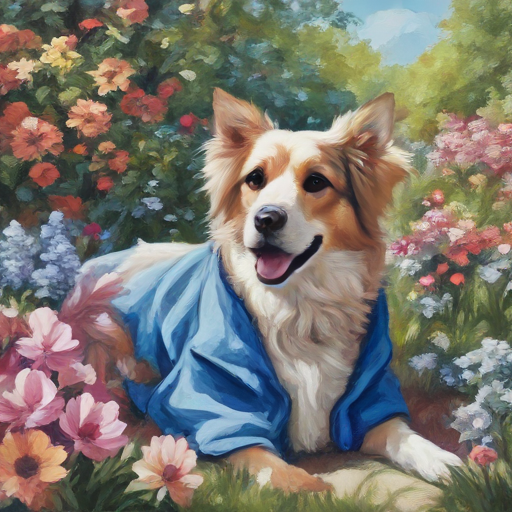

In [45]:
print(examples['prompt'][1])
examples['image'][1]


<div align="center"><img src="assets/Part3_done.png" alt="Intro to Ray" width="70%"></div>

<div style="border: 2px solid #4F8EF7; background: #F3F8FF; border-radius: 10px; padding: 18px; margin: 18px 0;">
<h2 style="color: #25396f; margin-top: 0;">📝 <span style="color:#3971CC;">Modify the <code>Enhancer</code> class and <code>seasonal_images</code> pipeline for parametrization</span></h2>

<ul style="font-size: 1.1em;">
  <li>Use variables contaioning the model name and the name of the dataset column containing the prompt as below</li>
</ul>
</div>

In [46]:
enhancer_model = "Qwen/Qwen2.5-0.5B-Instruct"
prompt_column = "prompt"

In [47]:
# try your code here: updated Enhancer class


In [48]:
# try your code here: updated pipelineto generate seasonal_images Ray dataset


<details>
    <summary style="font-size: small; color: ;"><b> Solution</b></summary>
 
 ```python
    # try your code here: updated Enhancer class
    class Enhancer():
        def __init__(self, model_name, prompt_column_name):
            self.pipe = pipeline("text-generation", model=model_name, device='cuda')
            self.prompt_column_name = prompt_column_name
            
        def chat(self, prompts):
            messages = []
            for p in prompts:
                season = random.choice(['winter', 'spring', 'summer', 'fall'])
                                    
                message = [{"role": "system", "content": "You are a helpful assistant." +
                            "Enhance the image description with two short elements corresponding to the " + season + 
                            "season. Keep animal wearing clothing and retain image medium information (like photo or painting). Return new description only, no intro."},
                            {"role": "user", "content": p }]
                messages.append(message)
            return [out[0]['generated_text'][-1]['content'] for out in self.pipe(messages, max_new_tokens=200, batch_size=2)]
        
        def __call__(self, batch):
            batch[self.prompt_column_name] = self.chat(batch[self.prompt_column_name])
            return batch


    # try your code here: updated pipelineto generate seasonal_images Ray dataset
    seasonal_images = animals_outfits.map_batches(expand_prompt) \
                        .map_batches(Enhancer, batch_size=4, compute=ray.data.ActorPoolStrategy(size=2), num_gpus=0.6, fn_constructor_args=[enhancer_model, prompt_column]) \
                        .map_batches(ImageGen, batch_size=8, compute=ray.data.ActorPoolStrategy(size=2), num_gpus=0.4)
 ```
</details>

In [49]:
# try your code here: updated Enhancer class
class Enhancer():
    def __init__(self, model_name, prompt_column_name):
        self.pipe = pipeline("text-generation", model=model_name, device='cuda')
        self.prompt_column_name = prompt_column_name
        
    def chat(self, prompts):
        messages = []
        for p in prompts:
            season = random.choice(['winter', 'spring', 'summer', 'fall'])
                                   
            message = [{"role": "system", "content": "You are a helpful assistant." +
                        "Enhance the image description with two short elements corresponding to the " + season + 
                        "season. Keep animal wearing clothing and retain image medium information (like photo or painting). Return new description only, no intro."},
                        {"role": "user", "content": p }]
            messages.append(message)
        return [out[0]['generated_text'][-1]['content'] for out in self.pipe(messages, max_new_tokens=200, batch_size=2)]
    
    def __call__(self, batch):
        batch[self.prompt_column_name] = self.chat(batch[self.prompt_column_name])
        return batch


In [50]:
# try your code here: updated pipelineto generate seasonal_images Ray dataset
seasonal_images = animals_outfits.map_batches(expand_prompt) \
                    .map_batches(Enhancer, batch_size=4, compute=ray.data.ActorPoolStrategy(size=2), num_gpus=0.6, fn_constructor_args=[enhancer_model, prompt_column]) \
                    .map_batches(ImageGen, batch_size=8, compute=ray.data.ActorPoolStrategy(size=2), num_gpus=0.4)

In [51]:
examples = seasonal_images.take_batch(4)

2025-12-11 01:22:15,026	INFO logging.py:397 -- Registered dataset logger for dataset dataset_98_0
2025-12-11 01:22:15,027	INFO limit_pushdown.py:140 -- Skipping push down of limit 4 through map MapBatches[MapBatches(ImageGen)] because it requires 8 rows to produce stable outputs
2025-12-11 01:22:15,034	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_98_0. Full logs are in /tmp/ray/session_2025-12-10_22-48-15_101330_2333/logs/ray-data
2025-12-11 01:22:15,035	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_98_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles], InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> JoinOperatorWithPolars[Join(num_partitions=1)] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(expand_prompt)] -> ActorPoolMapOperator[MapBatches(Enhancer)] -> ActorPoolMapOperator[MapBatches(ImageGen)] -> LimitOperator[limit=4]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- ListFiles 3: 0.00 row [00:00, ? row/s]

- ReadFiles 4: 0.00 row [00:00, ? row/s]

- Join(num_partitions=1) 5: 0.00 row [00:00, ? row/s]

Shuffle 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Join 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Repartition 8: 0.00 row [00:00, ? row/s]

Split Repartition 9:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(expand_prompt) 10: 0.00 row [00:00, ? row/s]

- MapBatches(Enhancer) 11: 0.00 row [00:00, ? row/s]

- MapBatches(ImageGen) 12: 0.00 row [00:00, ? row/s]

- limit=4 13: 0.00 row [00:00, ? row/s]

(MapWorker(MapBatches(Enhancer)) pid=21378, ip=10.0.173.154) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s] 
(MapWorker(MapBatches(Enhancer)) pid=21378, ip=10.0.173.154) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 3x across cluster]
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s] 
(MapWorker(MapBatches(Enhancer)) pid=21378, ip=10.0.173.154) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 5x across cluster]
Loading pipeline components...:  86%|████████▌ | 6/7 [00:00<00:00,  6.85it/s] [repeated 2x across 

In the fall season, an exquisite watercolor painting captures a serene scene where a majestic feline, adorned in a vibrant red scarf, lounges against a serene garden setting. The soft autumn sunlight filters through the leaves, casting a golden glow on the landscape. The cat's fur is smooth and glossy, contrasting beautifully with the earthy tones of the canvas. In the foreground, a small, friendly bird perches nearby, adding a touch of tranquility. The painting is titled "Winter Solitude," capturing the essence of a solitary creature reflecting on nature's beauty during this transitional period.


(MapWorker(MapBatches(Enhancer)) pid=21586, ip=10.0.173.154) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


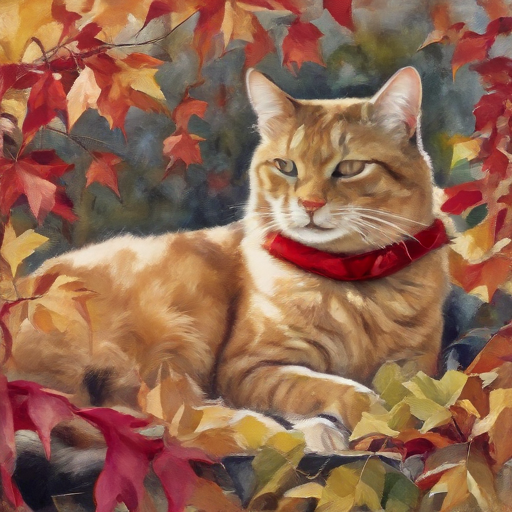

(MapWorker(MapBatches(Enhancer)) pid=23042, ip=10.0.187.206) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
(MapWorker(MapBatches(Enhancer)) pid=23042, ip=10.0.187.206) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 4x across cluster]
(MapWorker(MapBatches(Enhancer)) pid=21586, ip=10.0.173.154) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 3x across cluster]
(MapWorker(MapBatches(Enhancer)) pid=21586, ip=10.0.173.154) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repea

In [52]:
print(examples['prompt'][0])
examples['image'][0]

## 

<h2 style="color: #0f2027; background: linear-gradient(90deg, #43cea2 0%, #185a9d 100%); padding: 12px 0; border-radius: 8px; text-align:center; font-size: 2rem; letter-spacing: 1px;">
   <span style="color: #fff;">Thank You!</span> 
</h2>

<div align="center"><img src="assets/LI.png" alt="Intro to Ray" width="50%"></div>